Реализовать самостоятельно логистическую регрессию  
Обучить ее методом градиентного спуска  
Методом nesterov momentum  
Методом rmsprop  

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

В качестве dataset'а взять Iris, оставив 2 класса: Iris Versicolor и Iris Virginica  

In [2]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['target'])
df = pd.concat([X, y], axis=1)

Возьмем только 2 класса Iris Versicolor и Iris Virginica (индексы 1 и 2)

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
df = df[(df['target'] == 1) | (df['target'] == 2)]
df['target'] = df['target'].map({1 : 0, 2 : 1})
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['target'])
df.target.value_counts()

1    50
0    50
Name: target, dtype: int64

In [5]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


Построим логистическую регрессию, чтобы посмотреть качество и коэффициенты

In [6]:
scaler = StandardScaler()
scaler.fit(df.drop('target', axis=1))
df_scaled = scaler.transform(df.drop('target', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop('target', axis=1).columns)

In [7]:
X = df_scaled
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(log_reg.score(X_test, y_test))

1.0


Реализуем логистическую регрессию и обучим ее различными методами 
градиентным спуском

In [8]:
from sklearn.metrics import log_loss
from scipy.special import expit

class AbstractLogRegLearner:
    def __init__(self, features, labels, weights, learning_rate=0.0001, epochs=10000):
        self.features = features
        self.labels = labels
        self.weights = weights 
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.cost_history = []
        print('Init weights : ', weights.T)
        
    def cost_function(self):
        predictions = expit(np.dot(self.features, self.weights))
        return log_loss(self.labels, predictions, eps=1e-15)

    # customize this function
    def update_weights(self):
        raise('update_weights method is undefined. Use another Learner class')

    def train(self):
        self.cost_history = []
        for i in range(self.epochs):
            self.update_weights()
            self.cost_history.append(self.cost_function())

In [9]:
class GDLearner(AbstractLogRegLearner):
    def update_weights(self):
        predictions = expit(np.dot(self.features, self.weights))
        # градиент имеет вид, подобный виду линейной регрессии
        # с использованием numpy градиент можно записать в удобном виде
        gradient = self.learning_rate / len(self.features) \
            * np.dot(self.features.T,  predictions - self.labels.reshape(-1,1))
        self.weights -= gradient
        return

In [10]:
class NesterovMomentumLearner(AbstractLogRegLearner):    
    # gamma - coef used inside update_weights 
    def __init__(self, features, labels, weights, learning_rate=0.0001, epochs=10000, gamma=0.9):
        AbstractLogRegLearner.__init__(self, features, labels, weights, learning_rate, epochs)
        self.gamma = gamma
        self.old_velocity = 0
        
    def update_weights(self):
        predictions = expit(np.dot(self.features, self.weights))
        # gradient высчитываем с учетом скорости на предыдущем шаге
        gradient = self.learning_rate / len(self.features) \
            * np.dot(self.features.T,  predictions - self.labels.reshape(-1,1))
        velocity = self.gamma * self.old_velocity + gradient
        self.weights -= velocity
        self.old_velocity = velocity

In [11]:
class RMSPropLearner(AbstractLogRegLearner):
    def __init__(self, features, labels, weights, learning_rate=0.0001, epochs=10000, gamma=0.9):
        AbstractLogRegLearner.__init__(self, features, labels, weights, learning_rate, epochs)
        self.gamma = gamma
        self.e_grad_prev = 0

    def update_weights(self):
        predictions = expit(np.dot(self.features, self.weights))
        # gradient высчитываем с учетом скорости на предыдущем шаге
        gradient = self.learning_rate / len(self.features) \
            * np.dot(self.features.T,  predictions - self.labels.reshape(-1,1))
        e_grad = self.gamma * self.e_grad_prev + (1 - self.gamma) * (gradient ** 2)
        self.weights -= self.learning_rate * gradient / np.sqrt(e_grad)
        self.e_grad_pred = e_grad

Подготовим данные для расчета. Первая переменная - свободный коэффициент, остальные 4 - коэффициенты при фичах

In [12]:
features = np.hstack( (np.ones(len(y)).reshape(-1,1), X.as_matrix() ) )
labels = y.as_matrix()

In [13]:
weights = np.random.normal(size=(5,)).reshape(-1,1) 
print(weights)

[[ 0.81676304]
 [ 1.23981919]
 [ 1.38182212]
 [-0.27366588]
 [ 0.34856358]]


Обучим логистическую регрессию различными методами

Init weights :  [[ 0.81676304  1.23981919  1.38182212 -0.27366588  0.34856358]]
Gradient descent learner
Final weights :  [[0.27292991 0.82264849 0.35054524 0.67013495 1.48374973]]
Ideal weights :  [-0.00414641] [[-0.25860988 -0.5521781   2.14482214  2.16024848]]


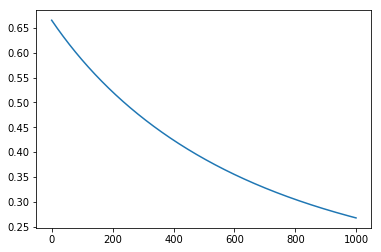

In [14]:
learner = GDLearner(features=features, labels=labels, weights=weights.copy(), 
                    learning_rate=0.01, epochs=1000)
learner.train()
print('Gradient descent learner')
print('Final weights : ', learner.weights.T)
print('Ideal weights : ', log_reg.intercept_, log_reg.coef_) 
plt.plot(learner.cost_history)

Init weights :  [[ 0.81676304  1.23981919  1.38182212 -0.27366588  0.34856358]]
Nesterov Momentum Learner
Final weights :  [[ 0.15442071 -0.29595937 -0.93983268  2.68329065  3.51920021]]
Ideal weights :  [-0.00414641] [[-0.25860988 -0.5521781   2.14482214  2.16024848]]


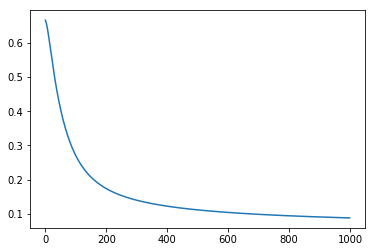

In [15]:
learner = NesterovMomentumLearner(features=features, labels=labels, weights=weights.copy(), 
                                  learning_rate=0.01, epochs=1000, gamma=0.9)
learner.train()
print('Nesterov Momentum Learner')
print('Final weights : ', learner.weights.T)
print('Ideal weights : ', log_reg.intercept_, log_reg.coef_) 
plt.plot(learner.cost_history)

Init weights :  [[ 0.81676304  1.23981919  1.38182212 -0.27366588  0.34856358]]
RMSProp Learner
Final weights :  [[-0.32165692 -1.60623071 -2.15992886  7.56878271  7.55855664]]
Ideal weights :  [-0.00414641] [[-0.25860988 -0.5521781   2.14482214  2.16024848]]


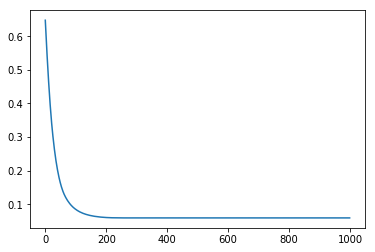

In [16]:
learner = RMSPropLearner(features=features, labels=labels, weights=weights.copy(), 
                         learning_rate=0.01, epochs=1000, gamma=0.9)
learner.train()
print('RMSProp Learner')
print('Final weights : ', learner.weights.T)
print('Ideal weights : ', log_reg.intercept_, log_reg.coef_) 
plt.plot(learner.cost_history)

Из приведенных графиков видно, что на одном и том же числе эпох (1000) и скорости обучения (0.01) сходимость у алгоритмов разная